In [1]:
from sklearn.model_selection import train_test_split
import pandas
import numpy
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from pprint import pprint
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.utils import resample

# Reading Data

In [2]:
data = pandas.read_csv('cs-training.csv')

# Data Preparation and Feature Extraction

In [3]:
data.dropna(axis=0,how='any',subset=['NumberOfDependents'],inplace=True)
data.dropna(axis=0,how='any',subset=['MonthlyIncome'],inplace=True)
data.reset_index()

train_frame = data[data.columns[1:]]
train_frame.columns[1:]

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [4]:
train_frame['MonthlyDebt'] = train_frame['DebtRatio']*train_frame['MonthlyIncome']
train_frame['NumOfPastDue'] = train_frame['NumberOfTimes90DaysLate']+train_frame['NumberOfTime60-89DaysPastDueNotWorse'] +train_frame['NumberOfTime30-59DaysPastDueNotWorse']

**Taking log transform to reduce skeweness in some variables**

In [5]:
for column in ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumOfPastDue', 'MonthlyDebt',
              'MonthlyIncome', 'DebtRatio', 'NumberRealEstateLoansOrLines']:
    train_frame['log_' + column] = numpy.log10(1 + train_frame[column].values)

**Removing outliers**

In [6]:
train_frame = train_frame[train_frame['age'] > 0]
train_frame = train_frame[train_frame['age'] < 99]

**Choosing features and splitting dataset**

In [7]:
features = ['log_RevolvingUtilizationOfUnsecuredLines', 'log_NumberOfTime30-59DaysPastDueNotWorse', 'log_NumberOfTimes90DaysLate', 'log_NumOfPastDue']
target = ['SeriousDlqin2yrs']
clust_frame = train_frame
x = clust_frame[features]
y = clust_frame['SeriousDlqin2yrs']
# x, y = oversample(x, y)

**Taking a scalar transform**

In [8]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

**Util methods to Train and Evaluate a model**

In [9]:
def evaluate(X, y_test, y_pred):
    ret_str = ''
    ret_str += 'Adjusted Rand Index: {}'.format( metrics.adjusted_rand_score(y_test, y_pred) ) + '\n'
    ret_str += 'Silhouette Coefficient: {}'.format( metrics.silhouette_score(X, y_pred, metric = "euclidean") )
    return ret_str   

In [10]:
def k_means(X, y_test):
    clustering = KMeans(n_clusters = 3, init = "k-means++", n_init = 4, max_iter=800, random_state = 0, algorithm = "auto").fit(X)
    clusters = clustering.labels_
    cont_matrix = metrics.cluster.contingency_matrix(y_test, clusters)
    ax = sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) #to fix glitch 
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Contingency matrix')
    plt.tight_layout()
    print(evaluate(X, y_test, clusters))
    return clusters

# Model Training and Evaluation

Adjusted Rand Index: 0.2139958631756294
Silhouette Coefficient: 0.6926897317802625


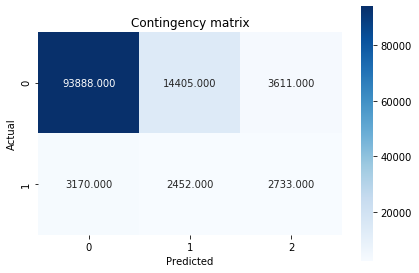

In [11]:
clust_frame['clusters'] = k_means(x, y)

# Cluster Analysis

Analysis of attributes of customers pertaining to the risk cluster they belong to <br>
<table style="width:50%">
  <tr>
    <th>Cluster</th>
    <th>Risk</th>
    <th>Color</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Low</td>
    <td>Green</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Medium</td>
    <td>Blue</td>
  </tr>
  <tr>
    <td>2</td>
    <td>High</td>
    <td>Red</td>
  </tr>
</table>

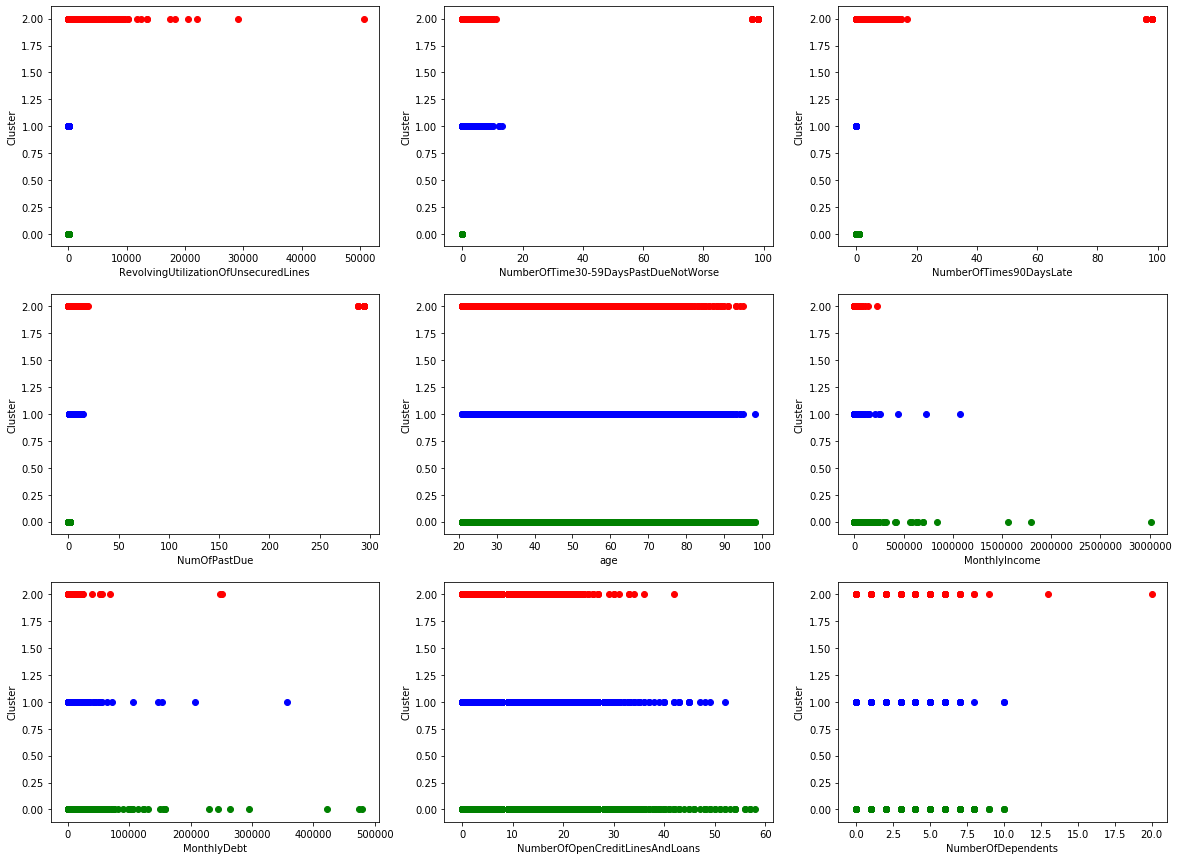

In [12]:
columns = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumOfPastDue',
                         'age', 'MonthlyIncome', 'MonthlyDebt', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfDependents']
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(20, 15)
for i in range(3):
    for j in range(3):
        col_name = columns.pop(0)
        ax[i, j].scatter(clust_frame[clust_frame['clusters'] == 2][col_name], clust_frame[clust_frame['clusters'] == 2]['clusters'], color='r')
        ax[i, j].scatter(clust_frame[clust_frame['clusters'] == 1][col_name], clust_frame[clust_frame['clusters'] == 1]['clusters'], color='b')
        ax[i, j].scatter(clust_frame[clust_frame['clusters'] == 0][col_name], clust_frame[clust_frame['clusters'] == 0]['clusters'], color='g')
        ax[i, j].set_xlabel(col_name)
        ax[i, j].set_ylabel('Cluster')
plt.show()

# Results and Conclusion

The attributes of customers in each cluster is clearly outlined in the plots above

<table style="width:100%">
  <tr>
    <th>Attribute</th>
    <th>Definition</th>
    <th>Observation from Each Cluster</th>
  </tr>
  <tr>
    <td>RevolvingUtilizationOfUnsecuredLines</td>
    <td>Percentage of credit utilized</td>
    <td>Observations in the low risk and medium risk clusters seem to have a low value. <br>However, observations in the high risk cluster have extremely high values for this attribute</td>
  </tr>
  <tr>
    <td>NumberOfTime30-59DaysPastDueNotWorse</td>
    <td>Number of payments late by 30 to 59 days</td>
    <td>The values for this attribute seem to be increasing as the risk increases.</td>
  </tr>
  <tr>
    <td>NumberOfTimes90DaysLate</td>
    <td>Number of payments late by more than 90 days</td>
    <td>As expected, the values for this attribute seem to be increasing as the risk increases.<br>Credit risk associated with a person is high when they are always late on their payments</td>
  </tr>
  <tr>
    <td>NumOfPastDue</td>
    <td>Total number of previous late payments</td>
    <td>People who make late payments consistently tend to have a higher credit risk</td>
  </tr>
  <tr>
    <td>Age</td>
    <td>Age of a person</td>
    <td>Age is evenly distributed across all clusters.<br>All clusters contain all age groups.</td>
  </tr>
  <tr>
    <td>MonthlyIncome</td>
    <td>Monthly income of a person</td>
    <td>Monthly income weakly decreases as the risk increases.<br>People with higher income have the ability to make payments on time</td>
  </tr>
  <tr>
    <td>MonthlyDebt</td>
    <td>Monthly debt payments</td>
    <td>Contraty to expectations, observations with high risk have more debts.<br>One interpretation is that people with high debts also have high income.<br>People with high income tend to get debts sanctioned more easily.</td>
  </tr>
  <tr>
    <td>NumberOfOpenCreditLinesAndLoans</td>
    <td>Number of credit and loan lines</td>
    <td>Like MonthlyDebt, people in the low risk region have more loans and credit lines. This can be interpreted the same way as MonthlyDebt. People with high income do tend to have many lines of credit.</td>
  </tr>
  <tr>
    <td>NumberOfDependents</td>
    <td>Number of depends of each individual</td>
    <td>Credit risk weakly increases with respect to increase in number of dependents. This makes sense because they have too many people to take care of to make payments on time.</td>
  </tr>
</table>